In [1]:
import s4bi
import matplotlib.pyplot as plt
from importlib import reload
from scipy import constants
from astropy.cosmology import Planck15
import qubic
from qubic import mcmc
import healpy as hp
import numpy as np
import os
import CMBS4
import qubicplus
#import fgbuster
import fgbuster
center = qubic.equ2gal(0, -57)
from fgbuster.component_model import (CMB, Dust, Dust_2b, Synchrotron, AnalyticComponent)
from fgbuster import basic_comp_sep, get_instrument
# If there is not this command, the kernel shut down every time..
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pickle

def separate(comp, instr, maps_to_separate, print_option=False):
    solver_options = {'eps':1e-5}
    solver_options['disp'] = False
    fg_args = comp, instr, maps_to_separate
    fg_kwargs = {'method': 'L-BFGS-B', 'options': solver_options}
    try:
        res = fgbuster.basic_comp_sep(*fg_args, **fg_kwargs)
    except KeyError:
        fg_kwargs['options']['disp'] = False
        res = fgbuster.basic_comp_sep(*fg_args, **fg_kwargs)
    if print_option:
        print()
        print("message:", res.message)
        print("success:", res.success)
        print("result:", res.x)
        
    return res

nside=256
def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

covmap = get_coverage(0.03, nside)

pkl_file = open('S4_dict.pkl', 'rb')
S4_dict = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('BI_dict.pkl', 'rb')
BI_dict = pickle.load(pkl_file)
pkl_file.close()

In [2]:
analytic_expr=s4bi.double_beta_dust_FGB_Model()

In [3]:
def sed(analytic_expr, nus, beta0, beta1, temp=20, hok=constants.h * 1e9 / constants.k, nubreak=200, nu0=200):
    sed_expr = AnalyticComponent(analytic_expr, 
                             nu0=nu0, 
                             beta_d0=beta0, 
                             beta_d1=beta1, 
                             temp=temp,
                             nubreak=nubreak, 
                             h_over_k = hok)
    return nus, sed_expr.eval(nus)
nus=np.linspace(1, 300, 200)
nb=100
nus, sed1b = sed(analytic_expr, nus, 1.54, 1.54, nubreak=nb)
nus, sed2b = sed(analytic_expr, nus, 0.5, 1.54, nubreak=nb)

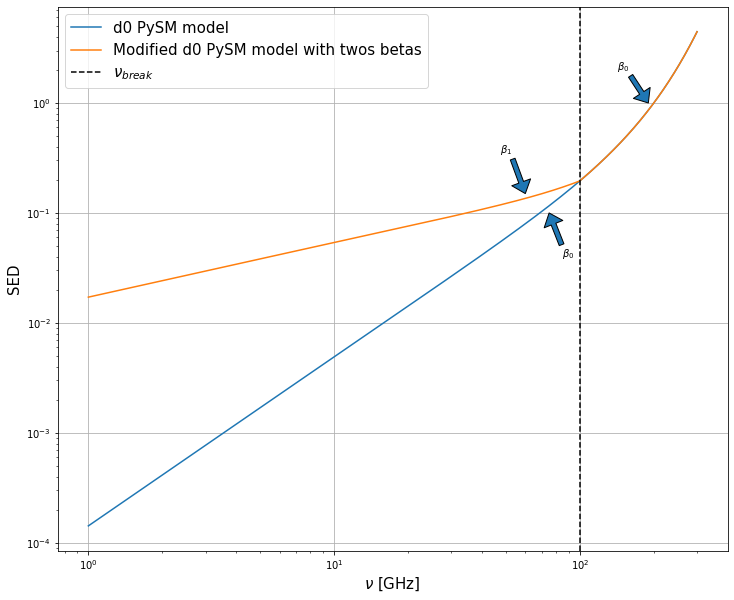

In [4]:
plt.figure(figsize=(12, 10))
plt.loglog(nus, sed1b, label = 'd0 PySM model')
plt.loglog(nus, sed2b, label = 'Modified d0 PySM model with twos betas')


plt.annotate(r'$\beta_{1}$', xy=(60, 0.15), xytext=(50, 0.35), arrowprops=dict(width=5, headwidth=20, lw=1), 
                                                             ha='center')

plt.annotate(r'$\beta_{0}$', xy=(190, 1), xytext=(150, 2), arrowprops=dict(width=5, headwidth=20, lw=1), 
                                                             ha='center')

plt.annotate(r'$\beta_{0}$', xy=(75, 0.1), xytext=(90, 0.04), arrowprops=dict(width=5, headwidth=20, lw=1), 
                                                             ha='center')


plt.xlabel(r'$\nu$ [GHz]', fontsize=15)
plt.ylabel(r'SED', fontsize=15)
plt.axvline(nb, ls='--', color='black', label=r'$\nu_{break}$')
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

In [5]:
skyconfig = {'dust':'d0'}

_, dustS4, _ = CMBS4.S4(skyconfig, S4_dict).getskymaps(
                                                        same_resol=1, 
                                                        iib=False, 
                                                        verbose=True, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1.)

    FWHM : [1. 1. 1. 1. 1. 1. 1. 1. 1.] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg


In [6]:
def scaling_factor(maps, nus, analytic_expr, beta0, beta1, nubreak):
    nb_nus = maps.shape[0]
    newmaps = np.zeros(maps.shape)
    #print(sed1b)
    for i in range(nb_nus):
        _, sed1b = sed(analytic_expr, nus[i], beta1, beta1, nu0=nus[i], nubreak=nubreak)
        _, sed2b = sed(analytic_expr, nus[i], beta0, beta1, nu0=nus[i], nubreak=nubreak)
        print('nu is {} & Scaling factor is {:.8f}'.format(nus[i], sed2b))
        newmaps[i] = maps[i] * sed2b
    return newmaps, sed1b, sed2b

thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

nb=100
new_dustS4, _, _ = scaling_factor(dustS4, S4_dict['frequency'], analytic_expr, 0.5, 1.54, nubreak=nb)

nu is 20.0 & Scaling factor is 5.33247471
nu is 30.0 & Scaling factor is 3.49779132
nu is 40.0 & Scaling factor is 2.59332895
nu is 85.0 & Scaling factor is 1.18414345
nu is 95.0 & Scaling factor is 1.05479351
nu is 145.0 & Scaling factor is 1.00000000
nu is 155.0 & Scaling factor is 1.00000000
nu is 220.0 & Scaling factor is 1.00000000
nu is 270.0 & Scaling factor is 1.00000000


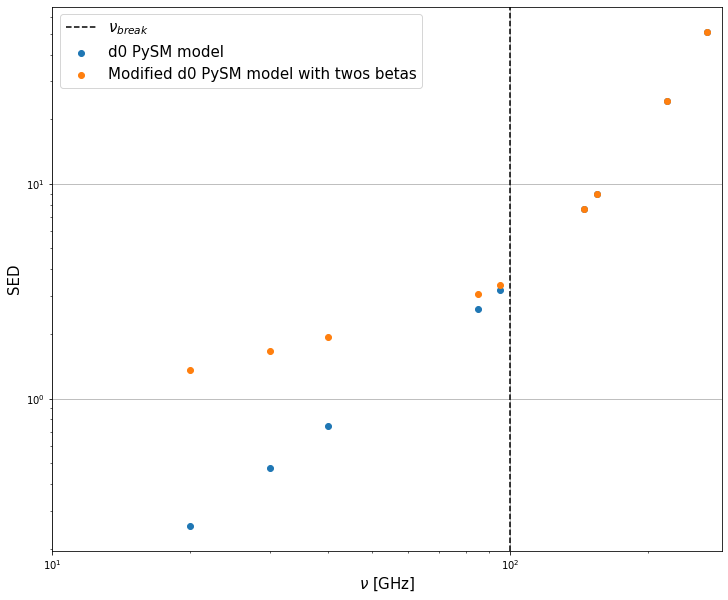

In [7]:
plt.figure(figsize=(12, 10))
plt.scatter(S4_dict['frequency'], np.mean(dustS4[:, :, pixok], axis=2)[:, 0], label = 'd0 PySM model')
plt.scatter(S4_dict['frequency'], np.mean(new_dustS4[:, :, pixok], axis=2)[:, 0], label = 'Modified d0 PySM model with twos betas')
nus=np.linspace(1, 300, 200)
#plt.loglog(nus, sed1b*18, label = 'd0 PySM model')
#plt.loglog(nus, sed2b*(25), label = 'Modified d0 PySM model with twos betas')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.xlabel(r'$\nu$ [GHz]', fontsize=15)
plt.ylabel(r'SED', fontsize=15)
plt.xlim(10, 290)
plt.axvline(nb, ls='--', color='black', label=r'$\nu_{break}$')
plt.legend(fontsize=15)
plt.show()

In [8]:
comp = [Dust_2b(nu0=110, nubreak=nb)]

instr = get_instrument('CMBS4')
instr.fwhm = np.ones(9)*1*60
r_s4_withoutiib=separate(comp, instr, new_dustS4[:, :, pixok])
print("   ", r_s4_withoutiib.x)

    [ 0.50001974  1.53993401 20.0054003 ]


    FWHM : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] deg 
    nus : [ 18.    19.    20.    21.    22.    26.4   28.2   30.    31.8   33.6
  35.2   37.6   40.    42.4   44.8   76.84  80.92  85.    89.08  93.16
  85.88  90.44  95.    99.56 104.12 132.24 138.62 145.   151.38 157.76
 141.36 148.18 155.   161.82 168.64 200.64 210.32 220.   229.68 239.36
 246.24 258.12 270.   281.88 293.76] GHz 
    Bandwidth : [ 1.    1.    1.    1.    1.    1.8   1.8   1.8   1.8   1.8   2.4   2.4
  2.4   2.4   2.4   4.08  4.08  4.08  4.08  4.08  4.56  4.56  4.56  4.56
  4.56  6.38  6.38  6.38  6.38  6.38  6.82  6.82  6.82  6.82  6.82  9.68
  9.68  9.68  9.68  9.68 11.88 11.88 11.88 11.88 11.88] GHz


Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvolution to 1.00 deg
Reconvo

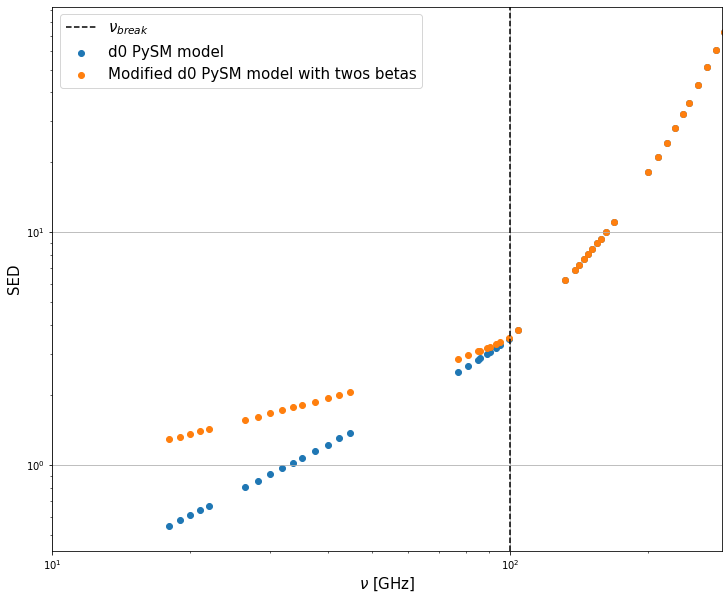

In [17]:
# let's try with QUBIC+

skyconfig = {'cmb':42}

_, cmbBI, _ = qubicplus.QUBICplus(skyconfig, BI_dict).getskymaps(
                                                        same_resol=1, 
                                                        iib=False, 
                                                        verbose=True, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1.)

_, dustBI, _ = qubicplus.QUBICplus({}, BI_dict).getskymaps(
                                                        same_resol=1, 
                                                        iib=False, 
                                                        verbose=True, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[1., 1.54, 100])

nb=100
#new_dustBI, _, _ = scaling_factor(dustBI, BI_dict['frequency'], analytic_expr, 0.5, 1.54, nubreak=nb)

plt.figure(figsize=(12, 10))
plt.scatter(BI_dict['frequency'], np.mean(dustBI[:, :, pixok], axis=2)[:, 0], label = 'd0 PySM model')
plt.scatter(BI_dict['frequency'], np.mean(new_dustBI[:, :, pixok], axis=2)[:, 0], label = 'Modified d0 PySM model with twos betas')
nus=np.linspace(1, 300, 200)
#plt.loglog(nus, sed1b*18, label = 'd0 PySM model')
#plt.loglog(nus, sed2b*(25), label = 'Modified d0 PySM model with twos betas')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.xlabel(r'$\nu$ [GHz]', fontsize=15)
plt.ylabel(r'SED', fontsize=15)
plt.xlim(10, 290)
plt.axvline(nb, ls='--', color='black', label=r'$\nu_{break}$')
plt.legend(fontsize=15)
plt.show()

In [18]:
maps = cmbBI + dustBI

In [19]:
comp = [Dust_2b(nu0=110, nubreak=nb), CMB()]

instr = get_instrument('Qubic+')
instr.fwhm = np.ones(45)*1*60
r_bi_withoutiib=separate(comp, instr, maps[:, :, pixok])
print("   ", r_bi_withoutiib.x)

    [ 1.00039222  1.54031674 19.98450918]


In [11]:
reload(qubicplus)

skyconfig = {'cmb':42}
dustS4, dustS4_n, _ = qubicplus.QUBICplus(skyconfig, BI_dict).getskymaps(
                                                        same_resol=0.1, 
                                                        iib=False, 
                                                        verbose=True, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1.,
                                                        beta=[1., 1.54, 200])

    FWHM : [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] deg 
    nus : [ 18.    19.    20.    21.    22.    26.4   28.2   30.    31.8   33.6
  35.2   37.6   40.    42.4   44.8   76.84  80.92  85.    89.08  93.16
  85.88  90.44  95.    99.56 104.12 132.24 138.62 145.   151.38 157.76
 141.36 148.18 155.   161.82 168.64 200.64 210.32 220.   229.68 239.36
 246.24 258.12 270.   281.88 293.76] GHz 
    Bandwidth : [ 1.    1.    1.    1.    1.    1.8   1.8   1.8   1.8   1.8   2.4   2.4
  2.4   2.4   2.4   4.08  4.08  4.08  4.08  4.08  4.56  4.56  4.56  4.56
  4.56  6.38  6.38  6.38  6.38  6.38  6.82  6.82  6.82  6.82  6.82  9.68
  9.68  9.68  9.68  9.68 11.88 11.88 11.88 11.88 11.88] GHz


Reconvolution to 0.10 deg
Reconvolution to 0.10 deg
Reconvolution to 0.10 deg
Reconvolution to 0.10 deg
Reconvolution to 0.10 deg
Reconvolution to 0.10 deg
Reconvolution

In [12]:
comp = [Dust_2b(nu0=100, temp=20., nubreak=200)]

instr = get_instrument('Qubic+')
instr.fwhm = np.ones(45)*1*60
r_bi_withoutiib=separate(comp, instr, dustS4[:, :, pixok])
print("   ", r_bi_withoutiib.x)

    [-0.34893185 -3.16808601]


In [13]:
r_bi_withoutiib.x[0]

-0.34893184815668016

In [20]:
reload(qubicplus)

cmbdust_modified, cmbdust_modified_noiseless, _  = qubicplus.QUBICplus({'cmb':42, 'dust':'d02b'}, BI_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[1., 1.54, 100])

Model is d02b
y
nu is 18.0 & Scaling factor is 2.52436905
nu is 19.0 & Scaling factor is 2.45173234
nu is 20.0 & Scaling factor is 2.38475519
nu is 21.0 & Scaling factor is 2.32274525
nu is 22.0 & Scaling factor is 2.26512280
nu is 26.4 & Scaling factor is 2.05273969
nu is 28.200000000000003 & Scaling factor is 1.98091336
nu is 30.0 & Scaling factor is 1.91581920
nu is 31.8 & Scaling factor is 1.85647607
nu is 33.6 & Scaling factor is 1.80209130
nu is 35.2 & Scaling factor is 1.75738519
nu is 37.599999999999994 & Scaling factor is 1.69589345
nu is 40.0 & Scaling factor is 1.64016524
nu is 42.400000000000006 & Scaling factor is 1.58936058
nu is 44.8 & Scaling factor is 1.54280086
nu is 76.84 & Scaling factor is 1.15287661
nu is 80.91999999999999 & Scaling factor is 1.12111413
nu is 85.0 & Scaling factor is 1.09172632
nu is 89.08 & Scaling factor is 1.06443388
nu is 93.16 & Scaling factor is 1.03900128
nu is 85.88 & Scaling factor is 1.08567116
nu is 90.44 & Scaling factor is 1.05576024


In [19]:
comp = [Dust_2b(nu0=100, nubreak=100), CMB()]

thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

instr = get_instrument('Qubic+')
instr.fwhm = np.ones(45)*1*60
r_bi_withoutiib=separate(comp, instr, cmbdust_modified_noiseless[:, :, pixok])
print("   ", r_bi_withoutiib.x)

    [ 1.00039222  1.54031674 19.98450918]
